In [13]:
import glob
import re
import numpy as np
from dictances import bhattacharyya
import sys
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os
%matplotlib inline

In [14]:
def normalization(array):
    max_of_array = np.max(array)
    normlized_array = array/max_of_array
    return normlized_array


#normalizing the array for processing before comparison
def return_normz(arr1):
    normz = []
    for x in arr1:
        z = (x - min(arr1))/(max(arr1) - min(arr1))
        normz.append(z)
    return normz

# softmax to normalize to a probability distribution
def softmax(x):
    e_x = np.exp(x - np.max(x))
    vals = e_x / e_x.sum()
    return vals

# introduce the array in the function
def making_dictionnaries(py_normz):
    value = 0
    string_index =[]
    for i in py_normz:
        value = value + 1
        str_in = "value" + str(value)
        string_index.append(str_in)
    return string_index

        
#Read all the arrayX from the file
def read_input_arrays(file_path='input_arrays.txt'):
    try:
        f = open(file_path, "r")
        file_content=f.read()
        file_array=file_content.split('\n')
        file_array=[item for item in file_array if item.replace(' ','')!='']
    except Exception as e:
        print(e)
        print("Error in reading file: "+str(file_path))
    casted_arrays={}
    for it,line in enumerate(file_array):
        try:
            temp_items=line.split('=')
            name=temp_items[0]
            array=temp_items[1][1:-1].replace(' ','').split(',')
            casted_arrays[name]=[float(item) for item in array if item!='']
        except Exception as e:
            print(e)
            print("Error in parsing array: "+str(it) +" : "+str(line))
            

        
    return casted_arrays

#Read all the simulations from the folders available from the directory
def find_all_simulations(directory=''):
    all_files=glob.glob(directory+"example?*/norm_downsampled_spectrum?*.txt")
    file_dict={}
    for file_name in all_files:
        try:
            f = open(file_name, "r")
            file_content=f.read()
        except Exception as e:
            print(e)
            print("Error in reading file: "+str(file_name))
            continue
        try:
            file_array=file_content[1:-1].split(' ')
            file_array=[item for item in file_array if item!='']
            file_array=[float(item.replace('\n','')) for item in file_array]
        except Exception as e:
            print(e)
            print("Error in parsing array of folder: "+str(file_name))
            continue
        try:
            temp_string=file_name.split('/')[-2]
            temp_string=re.findall('[0-9]',temp_string[0:temp_string.rfind('network')])[1:]
            file_dict["sim_"+temp_string[0]+temp_string[1]+temp_string[2]+"_"+temp_string[3]+temp_string[4]+"_"+temp_string[5]+temp_string[6]+"_"+temp_string[7]+temp_string[8]]=file_array
        except Exception as e:
            print(e)
            print("Error in parsing naming convention of folder: "+str(file_name))
            continue
    return file_dict


#compare arrayX with simulations with precision
def comparex(arrays_dict, sims_dict,prec):
    sims_matched_arrays={}
    for arr_key,arr_val in arrays_dict.items():
        patient_data = softmax(return_normz(normalization(arr_val).tolist())).tolist()
        norm_indices = making_dictionnaries(softmax(return_normz(normalization(arr_val).tolist())).tolist())
        dict_patient = dict(zip(norm_indices, patient_data))
        array_sims_local = []
        sims_matched_arrays[arr_key]=[]
        for k,v in sims_dict.items():
            normalized_sim = softmax(return_normz(normalization(v).tolist())).tolist()
            norm_indices = making_dictionnaries(softmax(return_normz(normalization(v).tolist())).tolist())
            dict_sim = dict(zip(norm_indices, normalized_sim ))
            array_sims_local.append(dict_sim.copy())
            comp_val = bhattacharyya(dict_patient, dict_sim)
            if(comp_val<=prec):
                sims_matched_arrays[arr_key].append(k)
    return sims_matched_arrays


def create_table(mappings,prec):
    df=pd.DataFrame(columns=mappings.keys(),index=[prec])
    for k,v in mappings.items():
        df[k][prec]=', '.join(v)
    return df

def create_viz(mappings,arrays,sims,freq):
    for key,val in mappings.items():
        plt.figure(figsize=(16, 4))
        plt.subplot(1, len(val)+1, 1)
        plt.plot(freq,arrays[key])
        plt.title(key)
        plt.xlabel('Frequency')
        plt.ylabel('Amplitude')
        for it,v in enumerate(val):
            plt.subplot(1, len(val)+1, it+2)
            plt.plot(freq,sims[v])
            plt.title(v)
            plt.xlabel('Frequency')
            plt.ylabel('Amplitude')
        plt.show()
        
def export_viz(mappings,arrays,sims,freq,prec):
    for key,val in mappings.items():
        plt.figure(figsize=(8, 4))
        plt.plot(freq,arrays[key])
        plt.title(key)
        plt.xlabel('Frequency')
        plt.ylabel('Amplitude')
        directory='comparison_precision_'+str(prec)+'/'+str(key)+'/'
        if not os.path.exists(directory):
            os.makedirs(directory)
        plt.savefig(directory+str(key)+'.png')
        plt.close()
        for it,v in enumerate(val):
            plt.figure(figsize=(8, 4))
            plt.plot(freq,sims[v])
            plt.title(v)
            plt.xlabel('Frequency')
            plt.ylabel('Amplitude')
            plt.savefig(directory+str(v)+'.png')
            plt.close()

In [15]:
arrays_dict=read_input_arrays()
sims_dict=find_all_simulations()
prec=0.002
result=comparex(arrays_dict,sims_dict,prec)
table=create_table(result,prec)
table.to_excel('matched_sims.xlsx')
table.head() 

,patient_1,patient_2,patient_3,patient_4,patient_5,patient_6,patient_7,patient_8,patient_9,patient_10,patient_11,patient_12
0.002,"sim_402_07_02_07, sim_407_03_02_03","sim_402_07_02_07, sim_405_03_02_03, sim_403_07...",,,,sim_407_07_02_07,sim_407_07_02_07,"sim_403_07_02_03, sim_408_03_02_07",sim_407_07_02_07,"sim_402_06_05_05, sim_402_05_06_05, sim_406_06...",sim_402_05_06_05,sim_407_07_02_07


In [16]:
freq = [32.0030,   34.1365,   36.2701,   38.4036,   40.5371,   42.6707,   44.8042,   46.9378,   49.0713,   51.2048,   53.3384,   55.4719,   57.6054,   59.7390,   61.8725,   64.0060,   66.1396,   68.2731,   70.4066,   72.5402,   74.6737,   76.8072,   78.9408,   81.0743,   83.2078,   85.3414,   87.4749,   89.6084]
export_viz(result,arrays_dict,sims_dict,freq,prec)

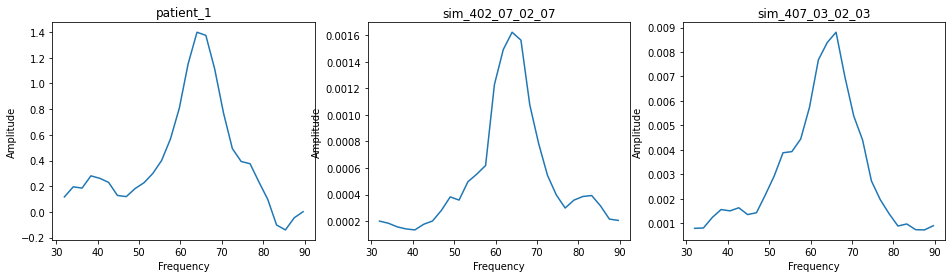

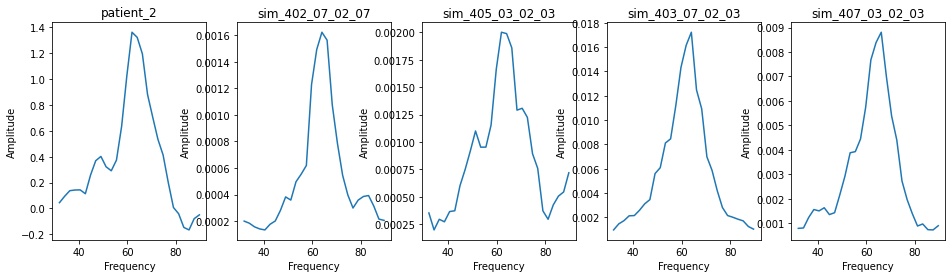

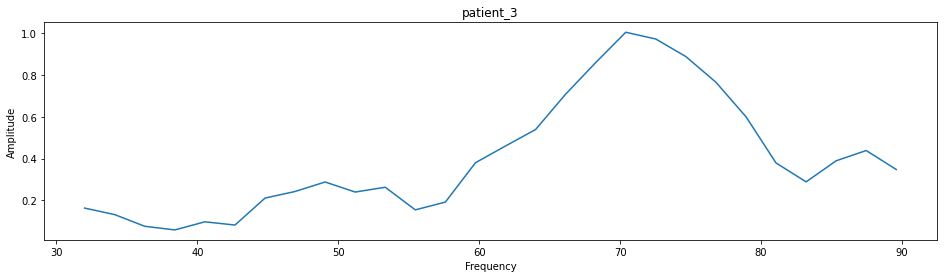

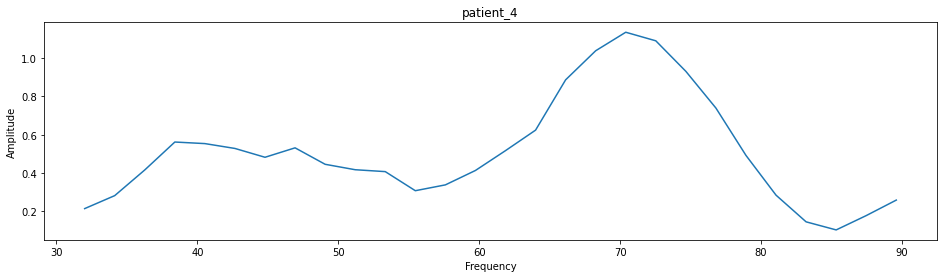

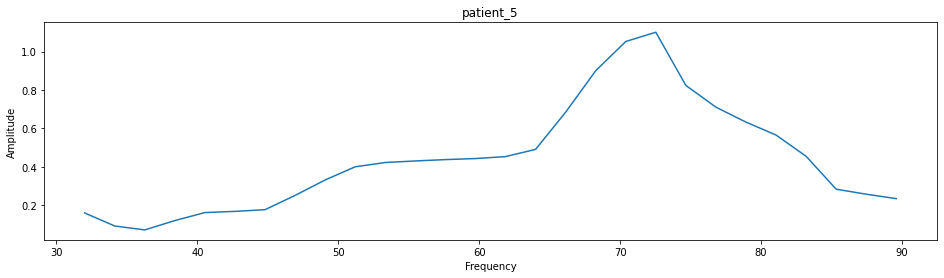

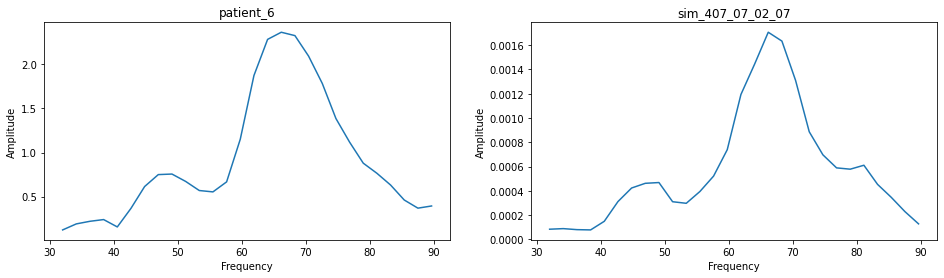

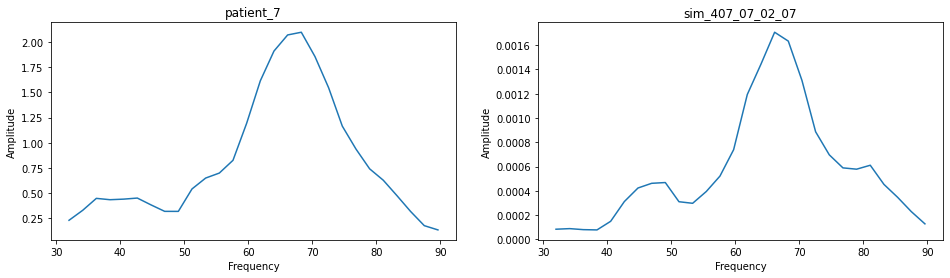

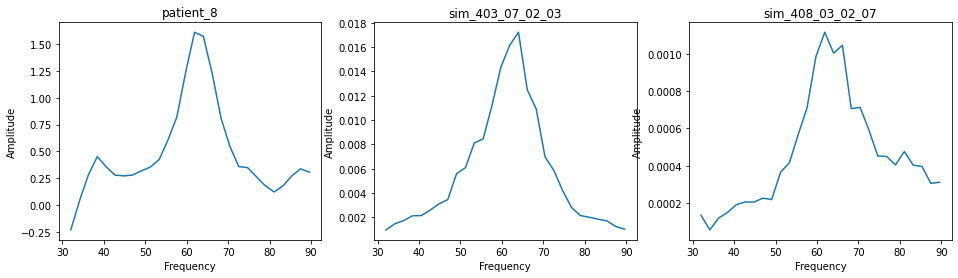

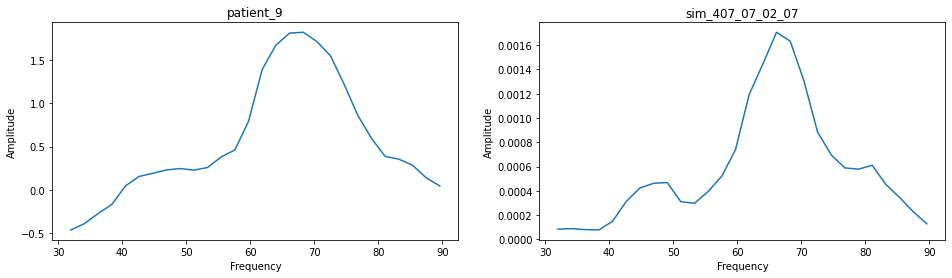

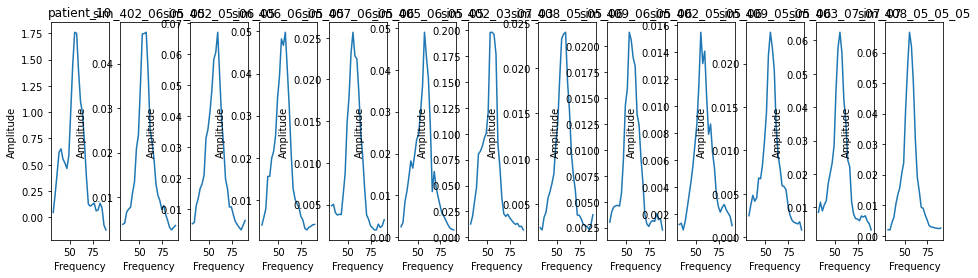

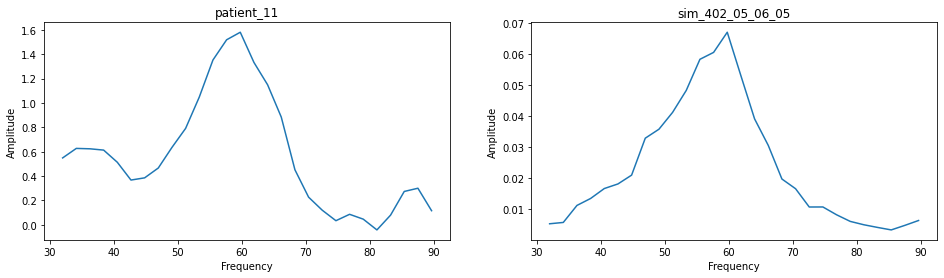

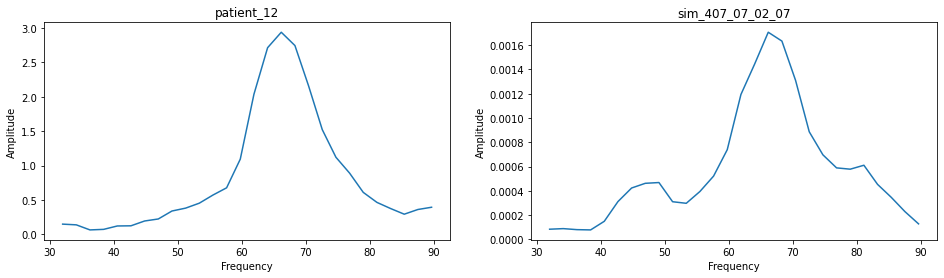

In [17]:
create_viz(result,arrays_dict,sims_dict,freq)